# 순환 신경망(RNN)을 이용한 문자열 생성
> 순환 신경망을 이용하여 문자열 수준의 언어 모델을 구성하고 이를 통해 문자열을 생성해 보았다. 

- toc: true
- badges: true
- author: 단호진
- categories: [nlp]

## 데이터

낱말 3만개, 17만개의 문자열로 구성된 H. G. Well의 The Time Machine을 이용하였다. 토큰 과정이나 ngram 분석은 [Dive into Deep Learning](https://d2l.ai/chapter_recurrent-neural-networks/language-models-and-dataset.html) 누리집을 참고하자. 데이터는 d2l 패키지에서 불러와 바로 사용할 수 있다.

참고

1. Aston Zhang 등, Dive into deep learning, https://d2l.ai/chapter_recurrent-neural-networks/rnn-concise.html

In [1]:
%matplotlib inline
from d2l import torch as d2l
import math
import torch
from torch import nn
from torch.nn import functional as F

batch_size, seq_len = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, seq_len)

device = torch.device('cpu')

torch.__version__

'1.7.1+cu110'

문자열은 알파벳 26자와 스페이스로 구성된다. 그 밖에 기호를 포함하여 모르는 문자는 unk에 저장되어 총 28개로 토큰화된다.

In [2]:
len(vocab)

28

In [3]:
', '.join([vocab.idx_to_token[k] for k in range(28)])

'<unk>,  , e, t, a, i, n, o, s, h, r, d, l, m, u, c, f, w, g, y, p, b, v, k, x, z, j, q'

훈련 데이터는 torch.long 타입으로 레이블 y는 입력 x가 한 글자씩 밀려 들어있다. 입력은 원핫 인코딩을 이용하여 변환하고 레이블은 그대로 이용하겠다.

In [4]:
for x, y in train_iter:
    break
    
x.shape, y.shape

(torch.Size([32, 35]), torch.Size([32, 35]))

In [5]:
x.dtype

torch.int64

In [6]:
x[0]

tensor([ 9,  2,  1,  3,  5, 13,  2,  1, 13,  4, 15,  9,  5,  6,  2,  1, 21, 19,
         1,  9,  1, 18,  1, 17,  2, 12, 12,  8,  5,  3,  9,  2,  1,  3,  5])

In [7]:
x0 = map(lambda idx: vocab.idx_to_token[idx], x[0])
''.join(list(x0))

'he time machine by h g wellsithe ti'

In [8]:
y0 = map(lambda idx: vocab.idx_to_token[idx], y[0])
''.join(list(y0))

'e time machine by h g wellsithe tim'

## 모델

단방향 순환 신경층을 구성할 수 있는 Pytorch의 RNN 클래스를 이용하였다. RNN의 마지막 타임스텝 출력만이 아니라 전체 시퀀스를 이용하며 각 출력은 선형층에 연결된다. 문자열 생성이 목적으로 과적합을 막기 위한 장치는 사용하지 않았다. Pytorch의 RNN 입력은 시퀀스(L)x배치(B)x특징 차원으로 주입된다.

In [9]:
class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.rnn = nn.RNN(input_size, hidden_size)  # batch_first: False
        self.linear = nn.Linear(hidden_size, input_size)
        
    def forward(self, x):
        out, _ = self.rnn(x)
        out = F.relu(out)
        out = map(lambda x: F.relu(self.linear(x)), out)
        out = torch.stack(list(out))
        return out

In [10]:
hidden_size = 512
input_size = vocab_size = len(vocab)

mod_0 = SimpleRNN(input_size, hidden_size)
mod_0.to(device)
mod_0.eval()

x = F.one_hot(x.T, 28).float()
print(f'input shape: (seq, batch, feature) {x.shape}')
y_pred = mod_0(x.to(device))
y_pred.shape

input shape: (seq, batch, feature) torch.Size([35, 32, 28])


torch.Size([35, 32, 28])

훈련 과정에서 lr을 크게 하면서도 수치적인 안정성을 유지하기 위하여 clip_grad_norm 함수를 사용하였다.

In [11]:
def train(model, train_iter, vocab, lr, num_epochs, device,
              use_random_iter=False):
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            legend=['train'], xlim=[10, num_epochs])
    # Initialize
    optimizer = torch.optim.SGD(model.parameters(), lr)
    
    # Train and predict
    for epoch in range(1, num_epochs + 1):
        l_sum = 0
        for x, y in train_iter:
            x = F.one_hot(x.T, 28).float()
            y = y.T.reshape(-1)
            out = model(x.to(device))
            l = loss(out.reshape((-1, 28)), y.to(device))
            optimizer.zero_grad()
            l.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            l_sum += l.item()
        animator.add(epoch, [l_sum])

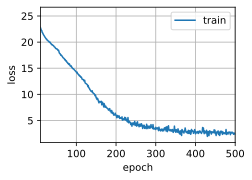

In [12]:
num_epochs, lr = 500, 0.5

hidden_size = 512
input_size = vocab_size = len(vocab)

mod_1 = SimpleRNN(input_size, hidden_size)
mod_1.to(device)

train(mod_1, train_iter, vocab, lr, num_epochs, device)

In [13]:
def generate(prefix, num_preds, model, vocab, device):
    model.eval()
    outputs = vocab[list(prefix)]
    for _ in range(num_preds):
        x = torch.tensor(outputs).reshape((-1, 1))
        x = F.one_hot(x, 28).float()
        out = model(x.to(device))
        out = torch.argmax(out[-1].squeeze())
        outputs.append(out.item())
    return ''.join([vocab.idx_to_token[i] for i in outputs])

out = generate('time traveller ', 60, mod_1, vocab, device)
out

'time traveller proceeded anyreal body must have extension in four direction'

## 맺으며

* 순환 신경망을 포함하는 문자열 생성 모델을 pytorch에서 구현
* map과 같은 python 함수를 사용해도 훈련이나 예측 과정에서 문제가 없음
* clip_grad_norm 함수를 사용하여 수치 불안정을 낮춤